# AutoencoderKL POC Encodings

This notebook generates the .npz files filled with the images latents, needed to run LightSB. 

## Imports

In [1]:
import os
import sys
import numpy as np
import copy

import diffusers
from diffusers import AutoencoderKL
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from CustomDataset import customDataset

import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from scripts.utils.generate_cfg import generate_cfg
from scripts.dataset.bdd_utils import get_bdd_dataset
from scripts.utils import get_dirs

/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Model

In [2]:
# CUDA -> MPS -> CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
# https://huggingface.co/docs/diffusers/api/models/autoencoderkl
url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"  # can also be a local file
model = AutoencoderKL.from_single_file(url)
model = model.to(device)

# no training, so set to eval mode
model.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

## Image, Resizing and Preprocessing

In [4]:
img = Image.open('/Users/jochem/Documents/GitHub/LightSB_YOLO/data/images/train/0a0a0b1a-7c39d841.jpg').convert('RGB')

In [ ]:
transf = transforms.Compose(
    [
        transforms.Resize((256,256)), # this makes the latent 4096 dim
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # model expects inputs in range [-1, 1], otherwise the image looks white
    ]
)

tensor_img = transf(img).to(device)

In [6]:
enc = model.encode(tensor_img.unsqueeze(0)) # adds batch dimension
print(enc.latent_dist.mode().shape)
print(enc.latent_dist.mode().ravel().shape) # latent shape

torch.Size([1, 4, 32, 32])
torch.Size([4096])


In [7]:
# scale back up to original size
upsample = transforms.Compose(
    [
        transforms.Resize((640,640)),
    ]
)

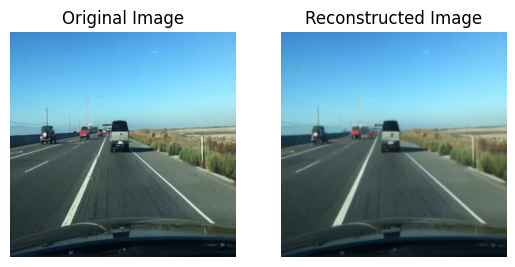

In [8]:
enc_latent = enc.latent_dist.sample()
rec = model.decode(enc_latent)
upsampled_rec = upsample(rec.sample.detach().cpu()) # breaks on mps so move to cpu

img_reconstructed = diffusers.utils.pt_to_pil(upsampled_rec)[0]

plt.figure()
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img.resize((640,640)))
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Reconstructed Image')
plt.imshow(img_reconstructed)
plt.axis('off')
plt.show()

## Load Data via YOLOPX

In [9]:
cfg = generate_cfg()

full_train_dataset = get_bdd_dataset(is_train=True)
full_val_dataset = get_bdd_dataset(is_train=False)

train_day = copy.copy(full_train_dataset)
train_day.db = train_day.select_data("daytime")

train_night = copy.copy(full_train_dataset)
train_night.db = train_night.select_data("night")

val_day = copy.copy(full_val_dataset)
val_day.db = val_day.select_data("daytime")

val_night = copy.copy(full_val_dataset)  
val_night.db = val_night.select_data("night")

/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


## Encoding Loop

In [10]:
def save_latents(latents, filename):
    encodings_path = os.path.join(get_dirs.get_base_dir(), "data", "encodings")
    file_path = os.path.join(encodings_path, filename)
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    np.save(file_path, latents)

In [ ]:
def generate_latents(db, split):
    latents = []

    transf = transforms.Compose(
        [
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # model expects inputs in range [-1, 1], otherwise the image looks white
        ]
    )
    
    dataset = customDataset(db, transf)

    loader = DataLoader(dataset, batch_size=8, num_workers=4, persistent_workers=True)
    
    # TODO: make robust to resume from checkpoint
    for batch in tqdm(loader):
        batch = batch.to(device)

        enc = model.encode(batch)
        enc_latent = enc.latent_dist.sample().detach()

        enc_latent = enc_latent.flatten(start_dim=1)
        enc_latent = enc_latent.cpu().numpy()
        
        latents.append(enc_latent) 

    latents_array = np.concatenate(latents)
    save_latents(latents_array, f"{split}_latents.npy")

### Day

In [12]:
train_day_latents = generate_latents(train_day.db, "train_day")

100%|██████████| 4600/4600 [38:14<00:00,  2.00it/s]


In [13]:
val_day_latents = generate_latents(val_day.db, "val_day")

100%|██████████| 658/658 [05:31<00:00,  1.99it/s]


### Night

In [14]:
train_night_latents = generate_latents(train_night.db, "train_night")

100%|██████████| 3504/3504 [29:36<00:00,  1.97it/s]


In [15]:
val_night_latents = generate_latents(val_night.db, "val_night")

100%|██████████| 492/492 [04:10<00:00,  1.96it/s]


## Get a few samples

In [16]:
val_day = np.load('../../data/encodings/val_day_latents.npy')
print(val_day.shape)

(5258, 4096)
